In [13]:
import os 
os.chdir('../')
import pandas as pd

In [22]:
dataframe = pd.read_csv('Work/chelombus/data/10M_ZINC_id_Sim_mqn.csv')

In [23]:
dataframe

,index,SMILES,ZINC_ID,DS_ID,Sim,MQN sum,MQN 1: Cyclic single bonds,MQN 2: Acyclic single bonds,MQN 3: Cyclic divalent bonds,MQN 4: Atoms in min. 2 rings,...,MQN 33: Acyclic tetravalent atoms,MQN 34: Count negative charges,MQN 35: Count 9-membered rings,MQN 36: Cyclic triple bonds,MQN 37: Count macrocycles,MQN 38: Count Cl,MQN 39: Count I,MQN 40: Count Br,MQN 41: Count F,MQN 42: Count P
0,0,Cc1oc2ccccc2c1C(=O)N(C)C[C@H]1CCN1C(=O)C1(C)CC1,977756639,0,1.000000,122,13,9,9,2,...,0,0,0,0,0,0,0,0,0,0
1,1,CN(C[C@@H]1CCN1C(=O)C1(C)CC1)C(=O)c1ccc2ccccc2c1,978382292,560318,0.594727,122,13,8,11,2,...,0,0,0,0,0,0,0,0,0,0
2,1,Cc1oc2ccccc2c1C(=O)N1CC[C@H]1CN(C)C(=O)[C@H]1C...,978191939,1488850,0.527344,122,13,9,8,2,...,0,0,0,0,0,0,0,0,0,0
3,2,Cc1oc2ccccc2c1C(=O)N(C)CCCN(C)C(=O)C(C)C,1066850312,357125,0.521484,116,6,13,5,2,...,0,0,0,0,0,0,0,0,0,0
4,1,Cc1oc2ccccc2c1C(=O)N(C)C1CN(C(=O)C2(C)CCC2)C1,954361420,894621,0.516602,121,14,8,10,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999996,1999928,O=c1[nH]cnc2c1ncn2[C@@H]1O[C@@H](COP(=O)(O)O)[...,4353761,1957934,0.000000,142,12,7,6,2,...,1,0,0,0,0,0,0,0,0,1
9999997,1999927,N[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@@H]1O,22059796,1943328,0.000000,78,6,6,1,0,...,0,0,0,0,0,0,0,0,0,0
9999998,1999926,Cn1nnc(CNS(=O)(=O)c2ncn(C)c2Cl)n1,398128103,680907,0.000000,95,6,7,5,0,...,1,0,0,0,0,1,0,0,0,0
9999999,1999925,Nc1nccnc1SCCO,230680812,1060805,0.000000,62,3,5,4,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from src.data_handler import DataHandler
data_handler = DataHandler()
smiles_list, features = data_handler.extract_smiles_and_features(dataframe)

In [5]:
features

array([[' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       ...,
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN ']], dtype=object)

In [6]:
from src.fingerprint_calculator import FingerprintCalculator
fp_calculator = FingerprintCalculator()

fingerprints = fp_calculator.calculate_fingerprints(smiles_list)

In [ ]:
from rdkit.Chem import rdMolDescriptors    
from rdkit import Chem

m = Chem.MolFromSmiles('CO[C@@H]1[C@@H](OC(N)=O)[C@@H](O)[C@H](Oc2ccc3c(O)c(NC(=O)c4ccc(O)c(CC=C(C)C)c4)c(=O)oc3c2C)OC1(C)C')

ds = rdMolDescriptors.MQNs_(m)                                                                    

len(ds)

In [9]:
fingerprints.shape

(38370, 42)

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing


def estimate_components(data_sample):
    # Assume data_sample is a NumPy array of shape (n_samples, n_features)
    
    # Step 2: Fit PCA without reducing dimensions
    pca = PCA(n_components=len(fingerprints[1]))
    pca.fit(data_sample)
    
    # Step 3: Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Step 4: Determine the number of components to retain desired variance
    threshold = 0.95  # For 95% variance
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Number of components to retain {threshold*100}% of variance: {n_components}")
    
    # Optional: Plot cumulative explained variance
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid(True)
    plt.show()
    
    return n_components


Number of components to retain 95.0% of variance: 3


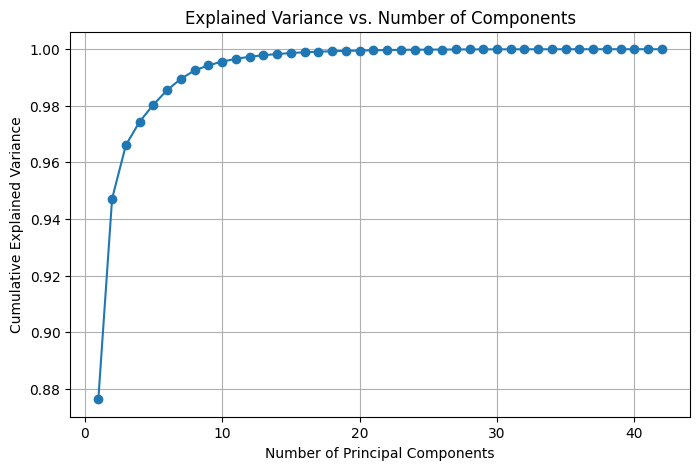

3

In [11]:
estimate_components(fingerprints)

Not good, should look into other FP that can reduce the number of dimensions and still conserve the variance

In [18]:
dataframe = dataframe.drop(columns= ['target_id', 'standard_type', 'target_name', 'standard_relation', 'standard_value', 'standard_units', 'target_organism'])

In [19]:
dataframe.to_csv('data/cleaned_dataset.csv', index = False)

In [1]:
import csv
import itertools
from math import sqrt

def euclidean_distance(p1, p2):
    return sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def find_most_similar_points(filename):
    points = []
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            points.append((float(row['x']), float(row['y']), float(row['z'])))

    min_distance = float('inf')
    most_similar = None

    for combo in itertools.combinations(range(len(points)), 10):
        p1, p2, p3 = [points[i] for i in combo]
        dist = (euclidean_distance(p1, p2) + 
                euclidean_distance(p2, p3) + 
                euclidean_distance(p3, p1))
        if dist < min_distance:
            min_distance = dist
            most_similar = (p1, p2, p3)

    return most_similar

# Usage
filename = '/home/afloresep/work/chelombus/data/output/batch_data_0.csv'
result = find_most_similar_points(filename)
print("The 3 most similar points are:", result)

The 3 most similar points are: ((1.7721422125559418, 1.3703430100724014, 1.9155553450241183), (1.7721422125559418, 1.3703430100724014, 1.9155553450241183), (1.7721422125559418, 1.3703430100724014, 1.9155553450241183))


This proves that same molecules are given the same coordinates

In [3]:
import csv
import itertools
from math import sqrt
from collections import defaultdict

def euclidean_distance(p1, p2):
    return sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def find_most_similar_points(filename):
    points = defaultdict(list)
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            point = (float(row['x']), float(row['y']), float(row['z']))
            points[point].append(i)

    unique_points = list(points.keys())
    
    if len(unique_points) < 3:
        return "Not enough unique points to find 3 most similar."

    min_distance = float('inf')
    most_similar = None

    for combo in itertools.combinations(range(len(unique_points)), 3):
        p1, p2, p3 = [unique_points[i] for i in combo]
        dist = (euclidean_distance(p1, p2) + 
                euclidean_distance(p2, p3) + 
                euclidean_distance(p3, p1))
        if dist < min_distance:
            min_distance = dist
            most_similar = (p1, p2, p3)

    return most_similar, min_distance

# Usage
filename = '/home/afloresep/work/chelombus/data/output/batch_data_0.csv'
result, distance = find_most_similar_points(filename)
print("The 3 most similar non-duplicate points are:", result)
print("Total distance between these points:", distance)

The 3 most similar non-duplicate points are: ((-1.4071302858277, 1.607233773614834, 1.0548155160181296), (-1.4168149250207485, 1.3376908007358967, 1.1341862100403879), (-1.5213659397180634, 1.5002080079195448, 1.1530337775164536))
Total distance between these points: 0.6601127597000824


In [ ]:
import csv
import itertools
from math import sqrt
from collections import defaultdict
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

def euclidean_distance(p1, p2):
    return sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def find_most_similar_points(filename, n=10):
    points = defaultdict(list)
    smiles_dict = {}
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            point = (float(row['x']), float(row['y']), float(row['z']))
            points[point].append(i)
            smiles_dict[point] = row['smiles']

    unique_points = list(points.keys())
    
    if len(unique_points) < n:
        return f"Not enough unique points to find {n} most similar."

    distances = []
    for combo in itertools.combinations(range(len(unique_points)), n):
        combo_points = [unique_points[i] for i in combo]
        dist = sum(euclidean_distance(p1, p2) 
                   for p1, p2 in itertools.combinations(combo_points, 2))
        distances.append((dist, combo_points))

    distances.sort(key=lambda x: x[0])
    return distances[0]

def plot_smiles(smiles_list):
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    
    for mol in mols:
        AllChem.Compute2DCoords(mol)
    
    rows = (len(smiles_list) + 4) // 5  # 5 molecules per row
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4*rows))
    fig.suptitle("2D Structures of 10 Most Similar Molecules", fontsize=16)

    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, (mol, ax) in enumerate(zip(mols, axes)):
        img = Draw.MolToImage(mol)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Structure {i+1}", fontsize=10)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
filename = '/home/afloresep/work/chelombus/data/output/batch_data_19531.csv'
result, distance = find_most_similar_points(filename)


In [ ]:
data_handler = DataHandler()

data_handler.find_input_type(file_path='test.csv')



In [ ]:
from tqdm import tqdm
import pickle


# Load all fingerprints with tqdm progress bar
fingerprints, smiles_list, features = [], [], []
for idx in tqdm(range(75), desc="Loading Fingerprints"):
    with open(f'data/fingerprints_chunk_{idx}.pkl', 'rb') as f:
        fps_chunk, smiles_chunk, features_chunk = pickle.load(f)
        fingerprints.extend(fps_chunk)
        smiles_list.extend(smiles_chunk)
        features.extend(features_chunk)

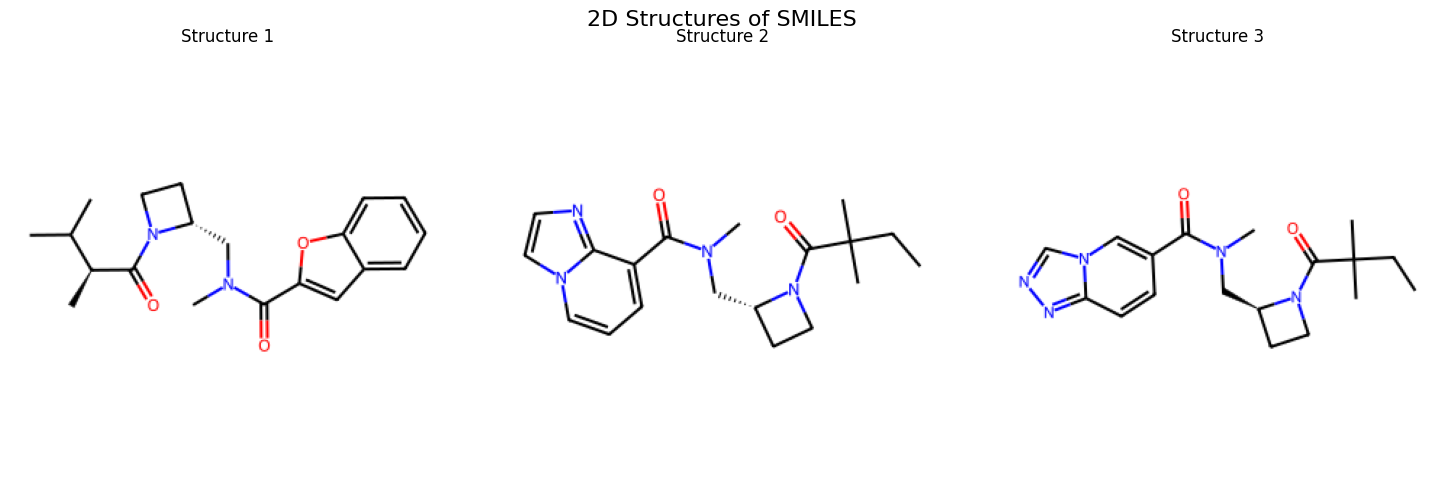

In [4]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

def plot_smiles(smiles_list):
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    
    # Generate 2D coordinates for each molecule
    for mol in mols:
        AllChem.Compute2DCoords(mol)
    
    # Create a 1x3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("2D Structures of SMILES", fontsize=16)

    for i, (mol, ax) in enumerate(zip(mols, axes)):
        img = Draw.MolToImage(mol)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Structure {i+1}", fontsize=12)

    plt.tight_layout()
    plt.show()

# SMILES strings
smiles = [
    'CC(C)[C@H](C)C(=O)N1CC[C@@H]1CN(C)C(=O)c1cc2ccccc2o1',
    'CCC(C)(C)C(=O)N1CC[C@@H]1CN(C)C(=O)c1cccn2ccnc12',
    'CCC(C)(C)C(=O)N1CC[C@H]1CN(C)C(=O)c1ccc2nncn2c1'
]

plot_smiles(smiles)

